### Bitcoin Prediction - Kaggle

In [41]:
#Installs kagglehub for dataset - uncomment if needed
#!pip install kagglehub
#!pip install prophet

# Imports libraries
import os
import requests
import json
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from datetime import datetime

In [42]:
# Download latest version of dataset
path = kagglehub.dataset_download("mczielinski/bitcoin-historical-data")

# List Path & files 
print("Dataset downloaded to:", path)
print("Files:", os.listdir(path))

# Load the CSV create 2 dataframes
csv_file = os.path.join(path, "btcusd_1-min_data.csv")
data = pd.read_csv(csv_file)
df = pd.read_csv(csv_file)

# Prints head to confirm
print(data.head())

Dataset downloaded to: C:\Users\Devin Ferko\.cache\kagglehub\datasets\mczielinski\bitcoin-historical-data\versions\353
Files: ['btcusd_1-min_data.csv']
      Timestamp  Open  High   Low  Close  Volume
0  1.325412e+09  4.58  4.58  4.58   4.58     0.0
1  1.325412e+09  4.58  4.58  4.58   4.58     0.0
2  1.325412e+09  4.58  4.58  4.58   4.58     0.0
3  1.325412e+09  4.58  4.58  4.58   4.58     0.0
4  1.325412e+09  4.58  4.58  4.58   4.58     0.0


In [43]:
# Convert Timestamp to datetime
data.Timestamp = pd.to_datetime(data.Timestamp, unit='s')

# Resampling to daily frequency
data.index = data.Timestamp
data = data.resample('D').mean()

# Resampling to monthly frequency
data_month = data.resample('ME').mean()

# Resampling to annual frequency
data_year = data.resample('YE-DEC').mean()

# Resampling to quarterly frequency
data_Q = data.resample('QE-DEC').mean()

# Prints head to confirm - Uncomment if needed
#data.head()
#data_month.head()
#data_year.head()
#data_Q.head()

##### We want to look at Volumne Weighted Average Price

What does the VWAP tell you?
VWAP is the abbreviation for volume-weighted average price, which is a technical analysis tool that shows the ratio of an asset's price to its total trade volume. It provides traders and investors with a measure of the average price at which a stock is traded over a given period of time.

In [44]:
# Calculates Weighted Value

data['Weighted_Price'] = (data['High'] + data['Low'] + data['Close']) / 3


In [45]:
# Calculates VWAP
vwap = data['Weighted_Price'] * data['Volume']

# Resamples to the specific frequencies - Daily, Monthly, Yearly, Quarterly - We then want to sum the VWAP and divide by the sum of the volume for each period
vwap_d = vwap.resample('D').sum() / data['Volume'].resample('D').sum()
vwap_m = vwap.resample('ME').sum() / data['Volume'].resample('ME').sum()
vwap_y = vwap.resample('YE-DEC').sum()  / data['Volume'].resample('YE-DEC').sum()
vwap_q = vwap.resample('QE-DEC').sum()  / data['Volume'].resample('QE-DEC').sum()

# Amends to DataFrame based on frequency
data = vwap_d.to_frame(name='Weighted Price')
data_month = vwap_m.to_frame(name='Weighted Price')
data_year = vwap_y.to_frame(name='Weighted Price')
data_Q = vwap_q.to_frame(name='Weighted Price')

# Prints head to confirm - Comment if needed
#data.head()
#data_month.head()
#data_year.head()
#data_Q.head()

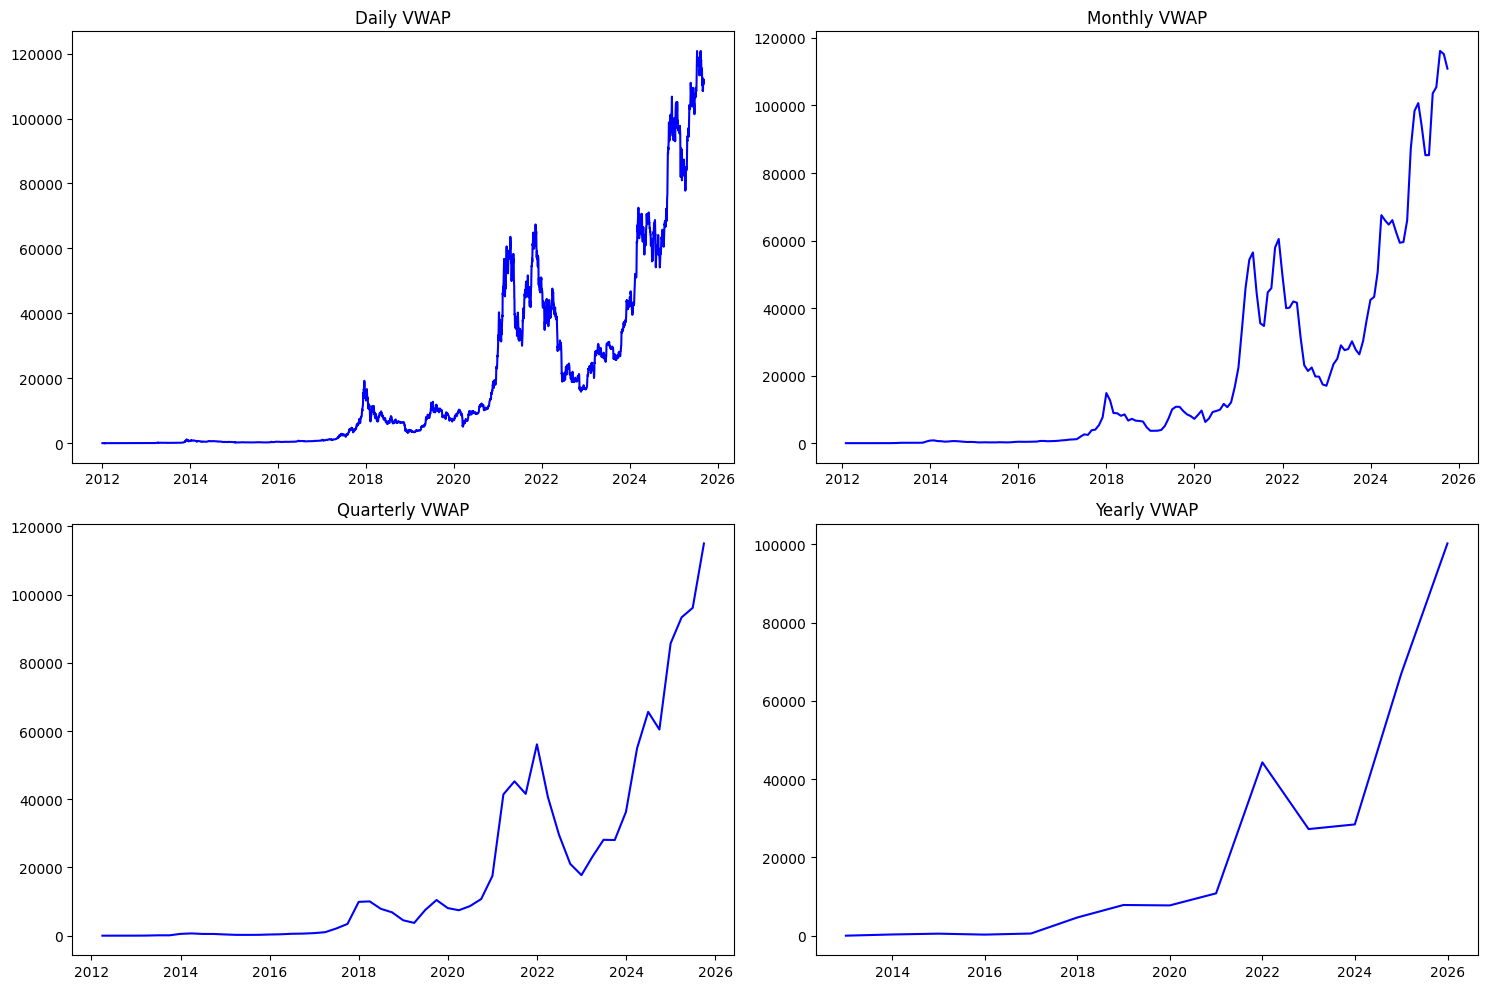

In [46]:
# Plot the above data to visualize trends

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Daily
axs[0,0].plot(data.index, data['Weighted Price'], color='blue')
axs[0,0].set_title('Daily VWAP')

# Monthly
axs[0,1].plot(data_month.index, data_month['Weighted Price'], color='blue')
axs[0,1].set_title('Monthly VWAP')

# Yearly
axs[1,0].plot(data_Q.index, data_Q['Weighted Price'], color='blue')
axs[1,0].set_title('Quarterly VWAP')

# Quarterly
axs[1,1].plot(data_year.index, data_year['Weighted Price'], color='blue')
axs[1,1].set_title('Yearly VWAP')

plt.tight_layout()
plt.show()


# Prediction Model

After a bit of research I decide to implentent a hybrid model.
    - Prophet - captures long-term trend + seasonality.
    - XGBoost - models short-term residuals that Prophet misses.

In [53]:
# Prophet Prediction Model

#convert timestamp to datetime then set as index
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
df.set_index('Timestamp', inplace=True)

# Daily Frequency
df_prophet = df[['Close']].resample('D').ffill().reset_index()
df_prophet = df_prophet.rename(columns={'Timestamp': 'ds', 'Close': 'y'})
df_prophet['y'] = np.log(df_prophet['y'])  # Log transform to stabilize variance

df_prophet.head()

KeyError: 'Timestamp'